# Density vs density-contrast

## import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

sys.path.insert(1, "../")

# local python scripts
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.plotting as plots
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.synthetic as synth

from antarctic_plots import utils, regions, maps, fetch, profile
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import harmonica as hm
import pygmt

PROJ: proj_create_from_database: Cannot find proj.db


## Get sample data

flat layer at 1km for top, and Bedmap2 bed for bottom

returning grid with new region and/or registration, same spacing


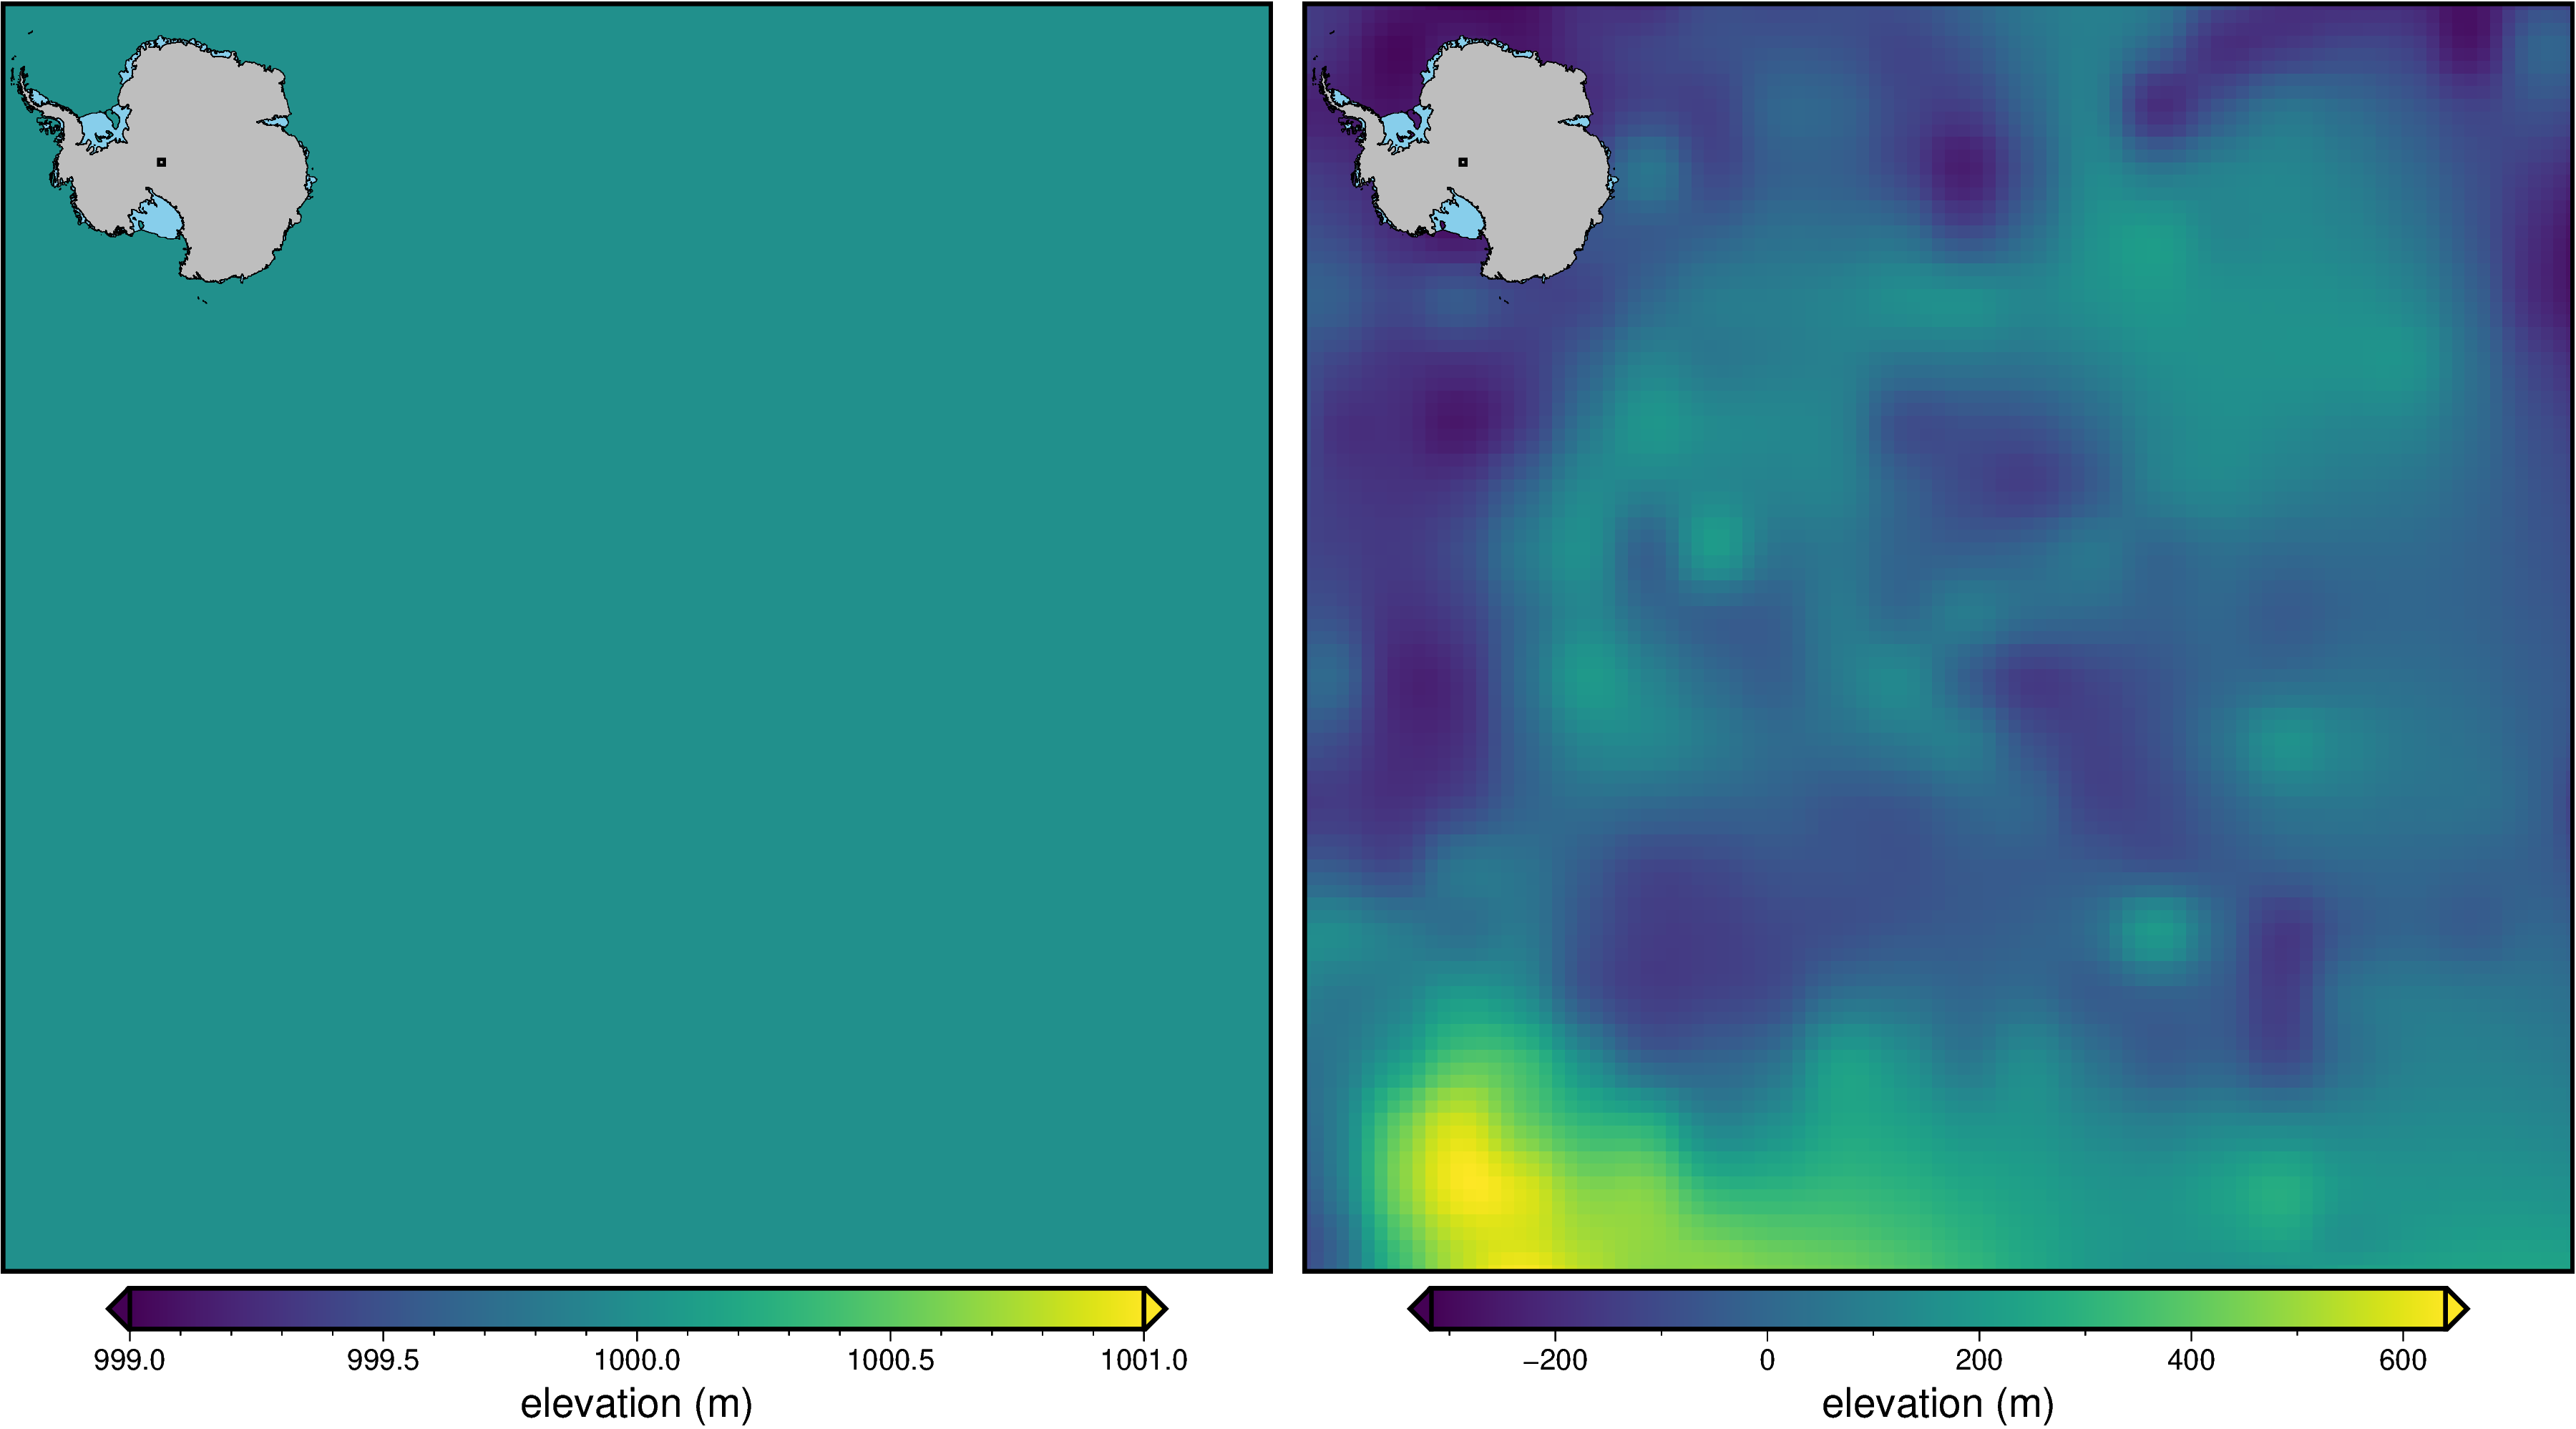

In [100]:
spacing = 1e3
region = [-50e3, 50e3, -50e3, 50e3]

# create grid of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
)
# create xarray dataarray from coordinates with a constant value of 0m
surface = vd.make_xarray_grid(
    coords, np.ones_like(coords[0]) * 1e3, data_names="z", dims=("y", "x")
).z

bed = fetch.bedmap2(layer='bed', region=region, spacing=spacing)

fig = maps.plot_grd(
    surface, 
    inset=True,
    titles='Surface',
    cbar_label='elevation (m)',
    cpt_lims=[999,  1001],
    )

fig = maps.plot_grd(
    bed, 
    inset=True,
    titles='Bed',
    cbar_label='elevation (m)',
    fig=fig,
    origin_shift='xshift',
    )
fig.show()

## Useful functions

In [57]:
def grids_to_prisms(
    top: xr.DataArray,
    bottom: xr.DataArray,
    density,
    **kwargs,
):
    # if density provided as a single number, use it for all prisms
    if isinstance(density, (float, int)):
        dens = density * np.ones_like(top)
    # if density provided as a dataarray, map each density to the correct prisms
    elif isinstance(density, xr.DataArray):
        dens = density
    else:
        raise ValueError("invalid density type, should be a number or DataArray")

    # create layer of prisms based off input dataarrays
    prisms = hm.prism_layer(
        coordinates=(top.x.values, top.y.values),
        surface=top,
        reference=bottom,
        properties={
            "density": dens,
            "thickness": top - bottom,
        },
    )

    return prisms


def forward_grav_of_prismlayer(
    prisms: list,
    observation_points: tuple,
    plot: bool = True,
    **kwargs,
):
    grids = []
    for i, p in enumerate(prisms):
        grav = p.prism_layer.gravity(
            coordinates=observation_points,
            field="g_z",
            progressbar=True,
        )
        grav_grid = vd.make_xarray_grid(
            coordinates=observation_points,
            data=grav,
            data_names="grav",
            extra_coords_names="height",
        ).grav

        grids.append(grav_grid)

    def sum_list(l):
        total = 0
        for x in l:
            total += x
        return total

    if len(grids) > 1:
        total_forward = sum_list(grids)
        grids.append(total_forward)
        # grids.insert(0, total_forward)

    if plot is True:
        for i, g in enumerate(grids):
            if i == 0:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title=kwargs.get("names", "Forward gravity of prisms")[0],
                    coast=True,
                )
            elif i == len(grids) - 1:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title="Total forward gravity",
                    coast=True,
                    fig=fig,
                    origin_shift="xshift",
                )
            else:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title=kwargs.get("names", "Forward gravity of prisms")[i],
                    coast=True,
                    fig=fig,
                    origin_shift="xshift",
                )
        fig.show()

    return grids

## Make prism layers

In [93]:
ice_prisms = grids_to_prisms(
    surface,
    bed,
    density=917,
)

bed_prisms = grids_to_prisms(
    bed,
    bed.values.min(),
    density=2030,
)

plots.show_prism_layers(
    [ice_prisms, bed_prisms],
    cmap="viridis",
    color_by='density',
    # color_by="thickness",
    clip_box=False,
    zscale=20,
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Calculate forward gravity

### create observation points

In [112]:
observation_points = vd.grid_coordinates(
    utils.alter_region(region, zoom=20e3)[0], 
    spacing=spacing, 
    extra_coords=1200,
    )

  0%|          | 0/3721 [00:00<?, ?it/s]

  0%|          | 0/3721 [00:00<?, ?it/s]

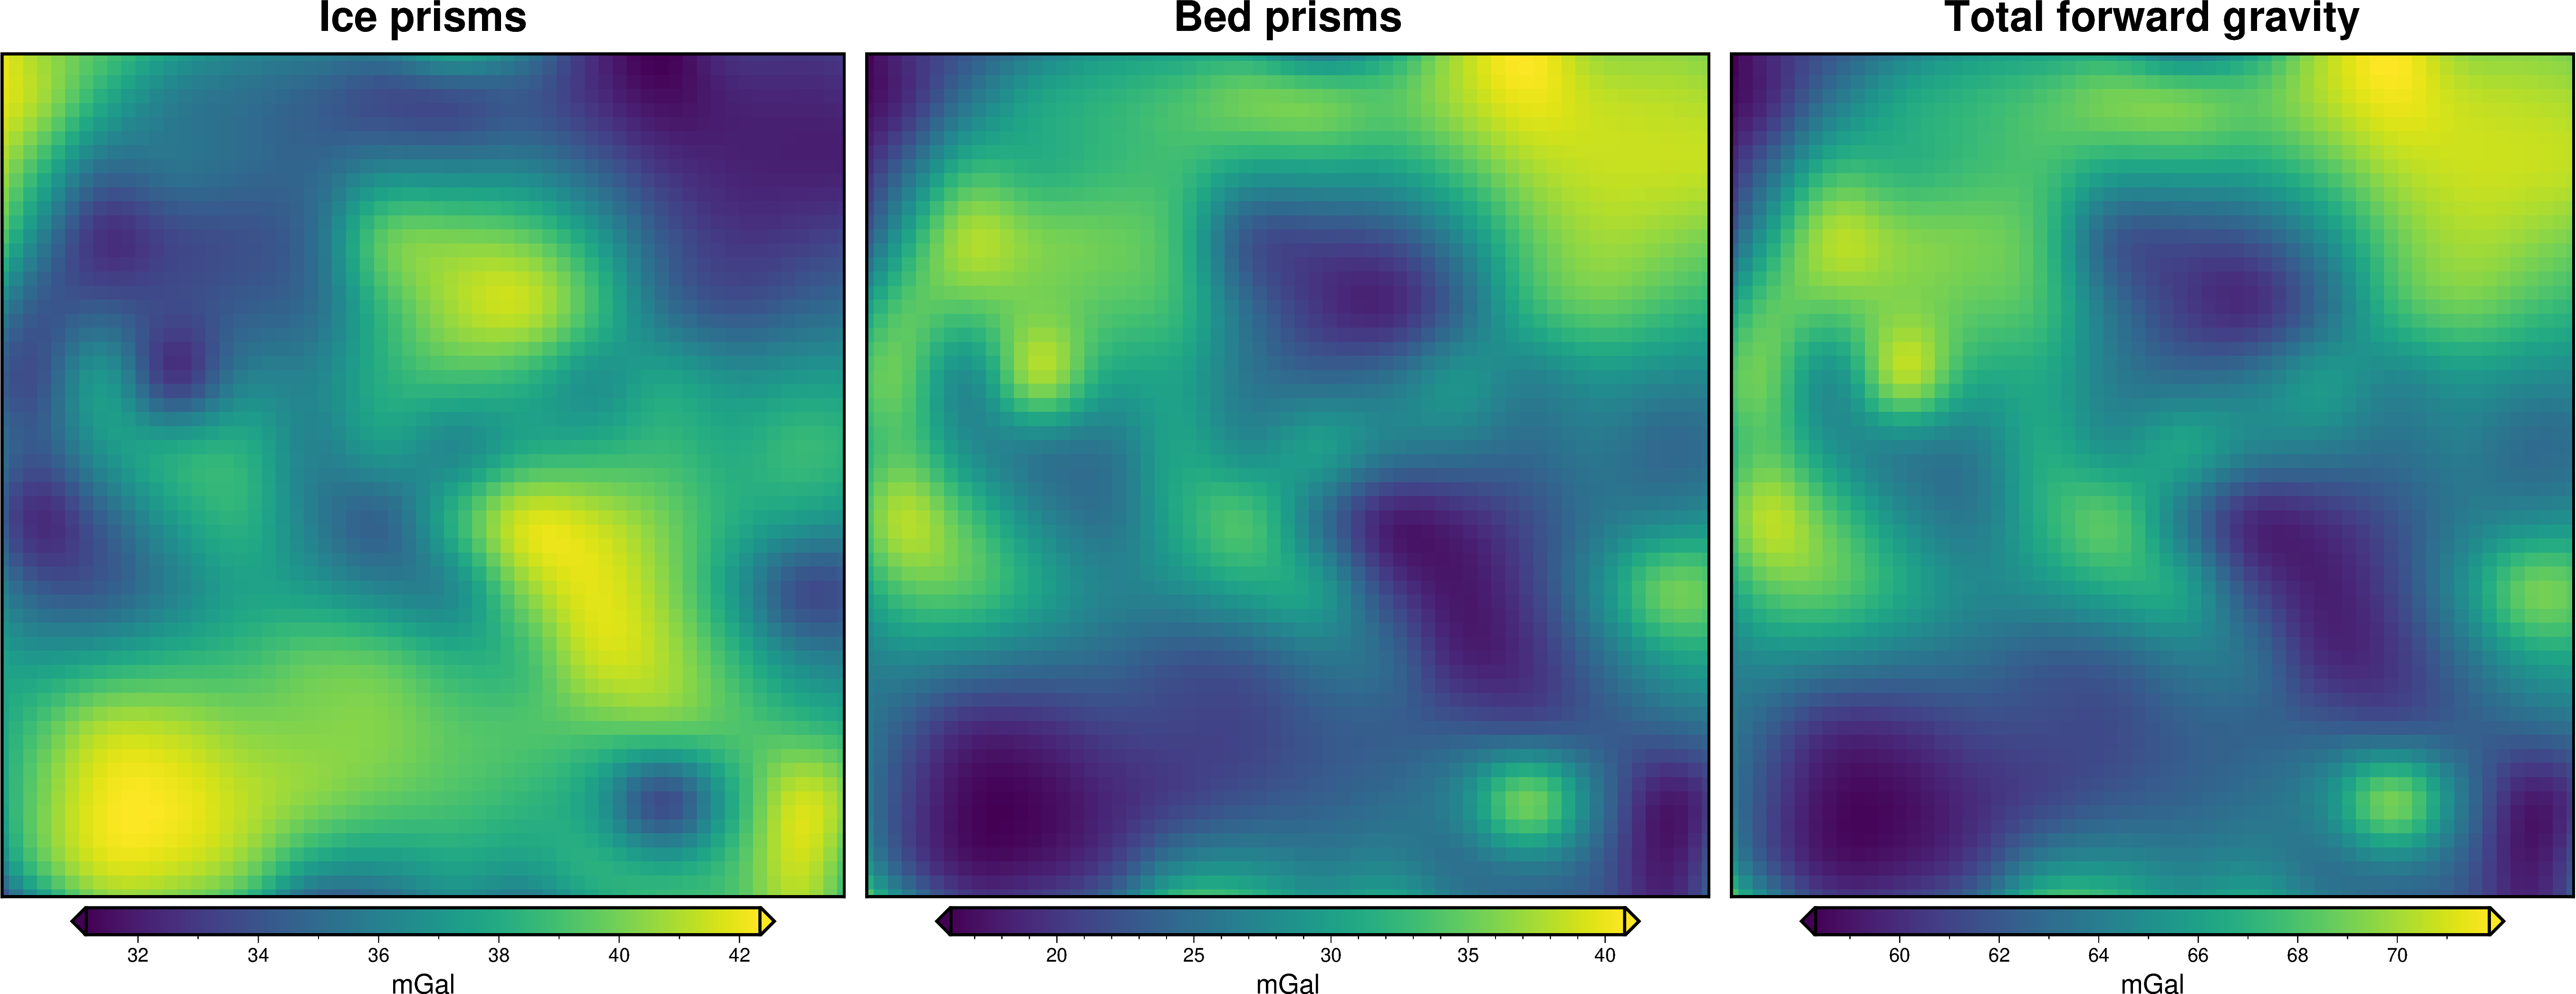

In [114]:
forward_absolute = forward_grav_of_prismlayer(
    [ice_prisms, bed_prisms],
    observation_points,
    plot=True,
    names=["Ice prisms", "Bed prisms"],
)

In [115]:
bed_prisms_contrast = grids_to_prisms(
    bed,
    bed.values.min(),
    density=2030-917,
)

plots.show_prism_layers(
    [bed_prisms_contrast],
    cmap="viridis",
    color_by='density',
    # color_by="thickness",
    clip_box=False,
    zscale=20,
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

  0%|          | 0/3721 [00:00<?, ?it/s]

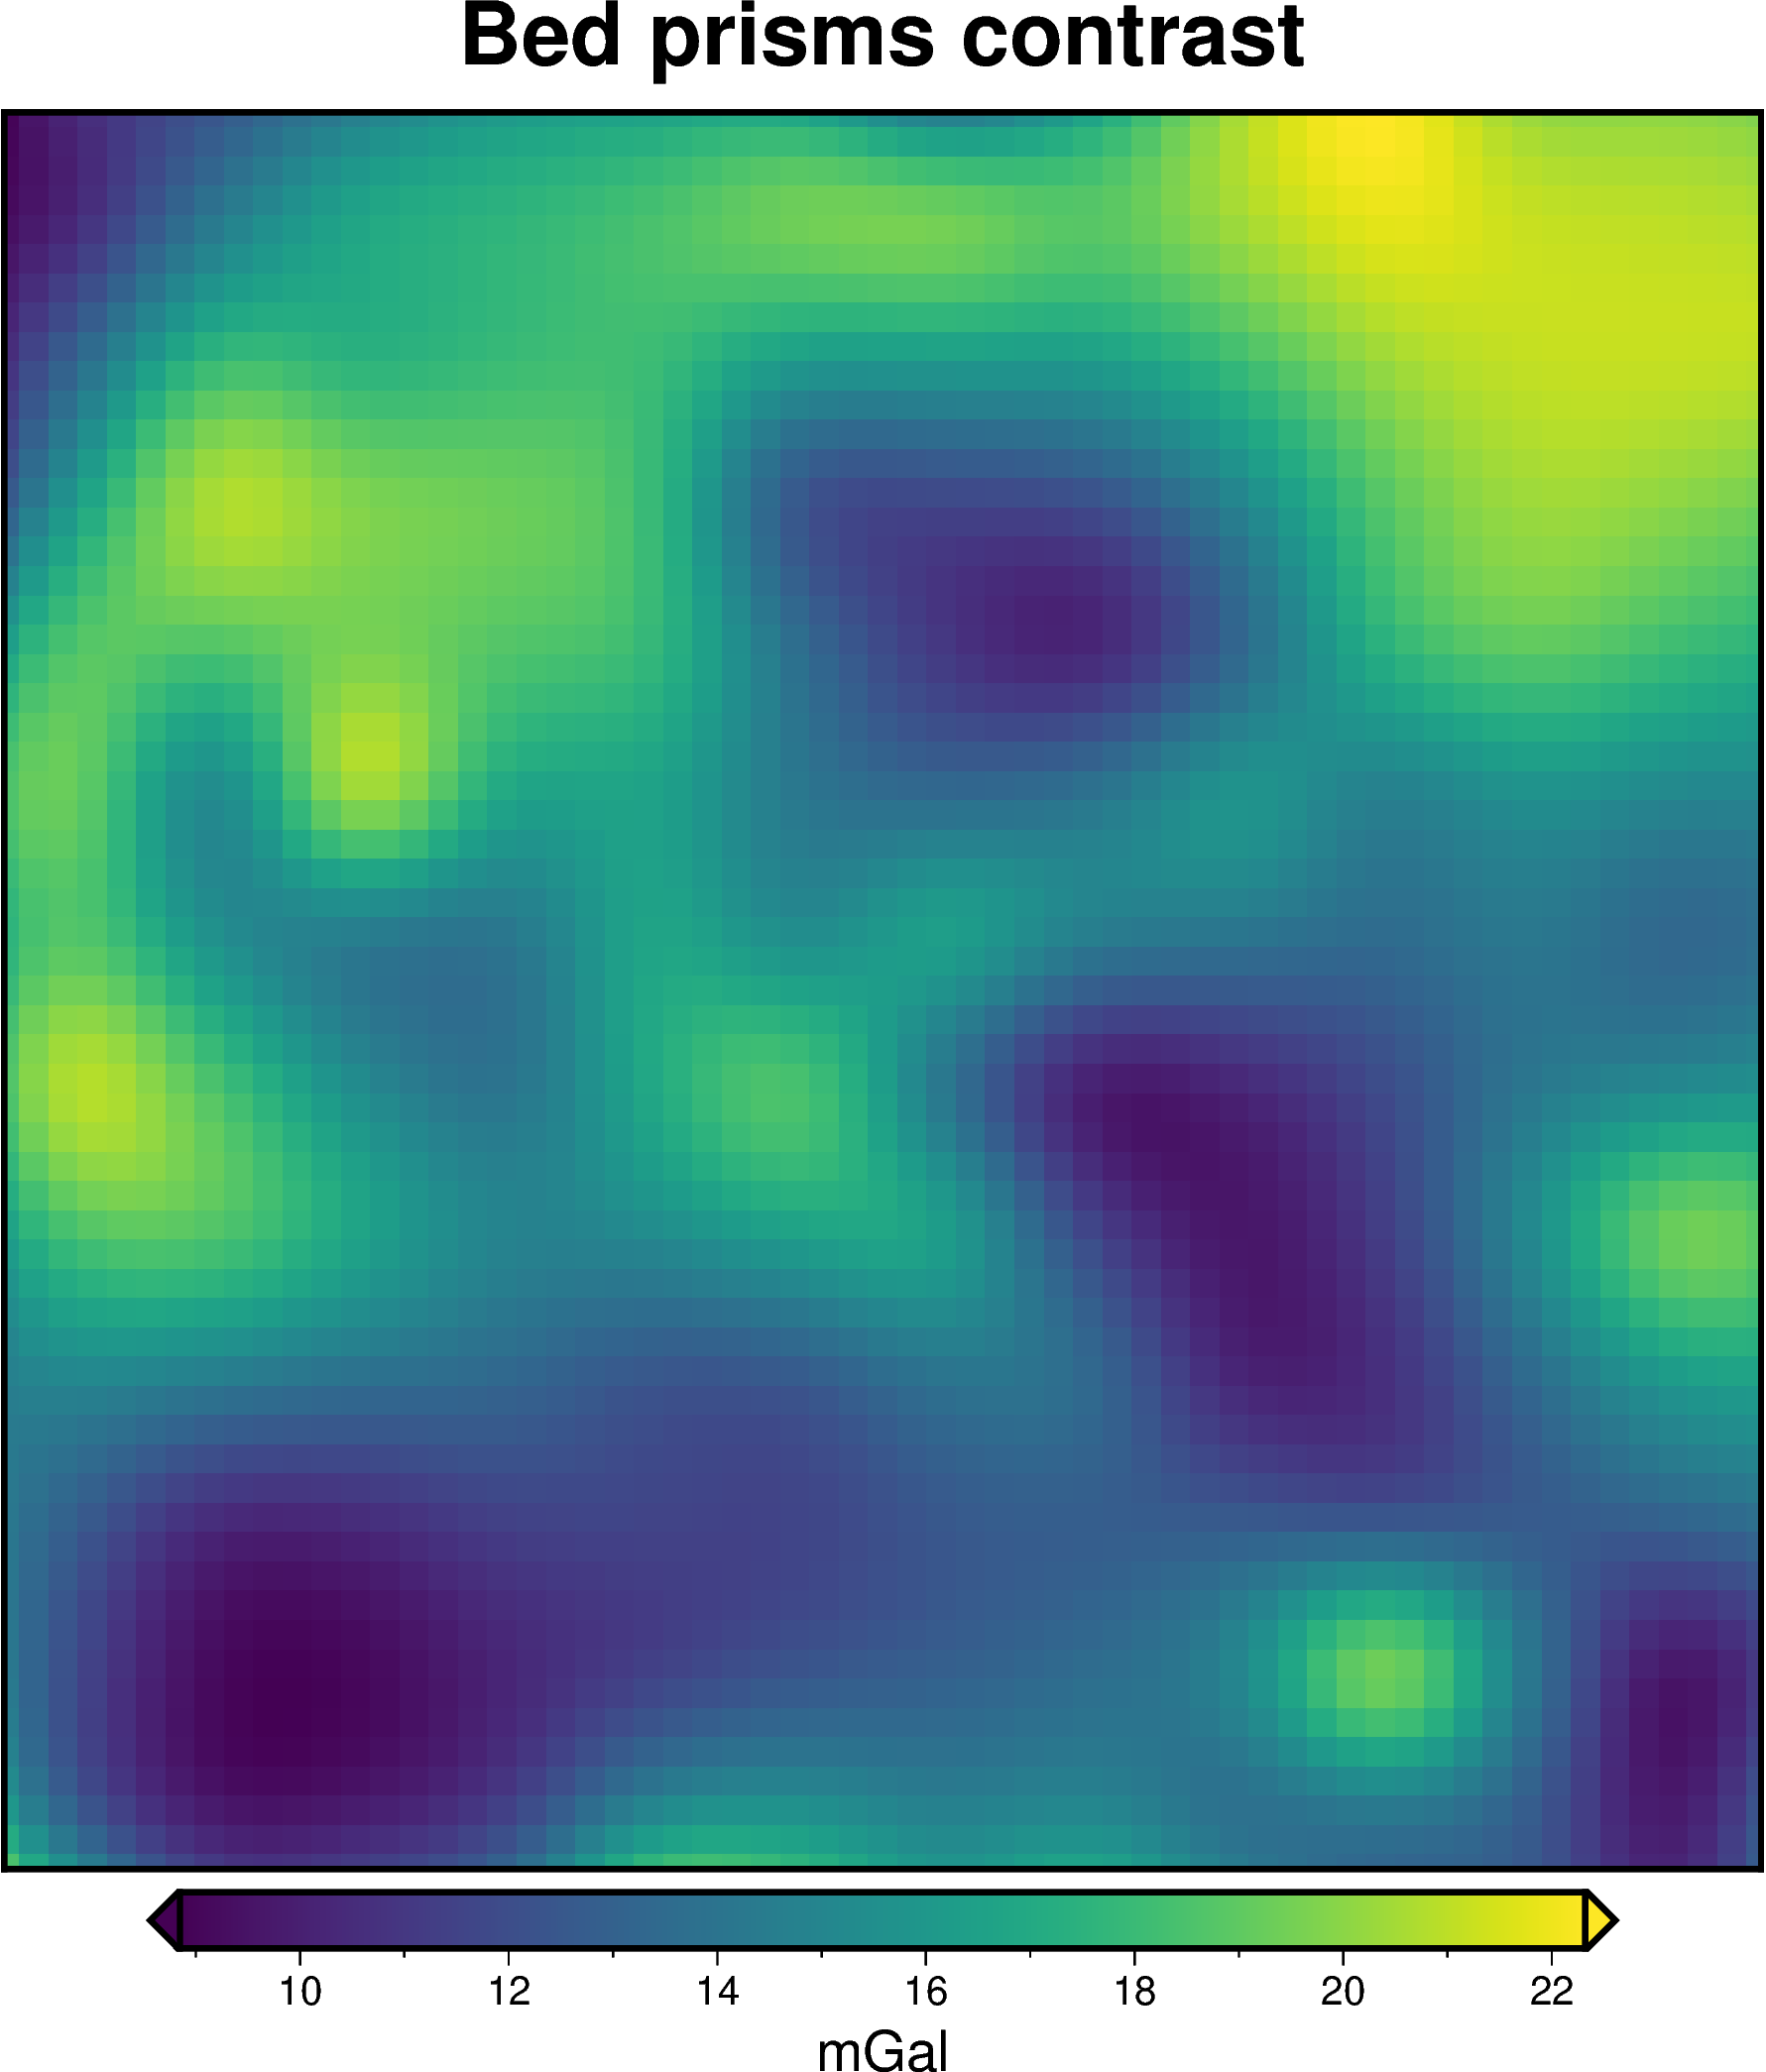

In [116]:
forward_contrast = forward_grav_of_prismlayer(
    [bed_prisms_contrast],
    observation_points,
    plot=True,
    names=["Bed prisms contrast"],
)[0]

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


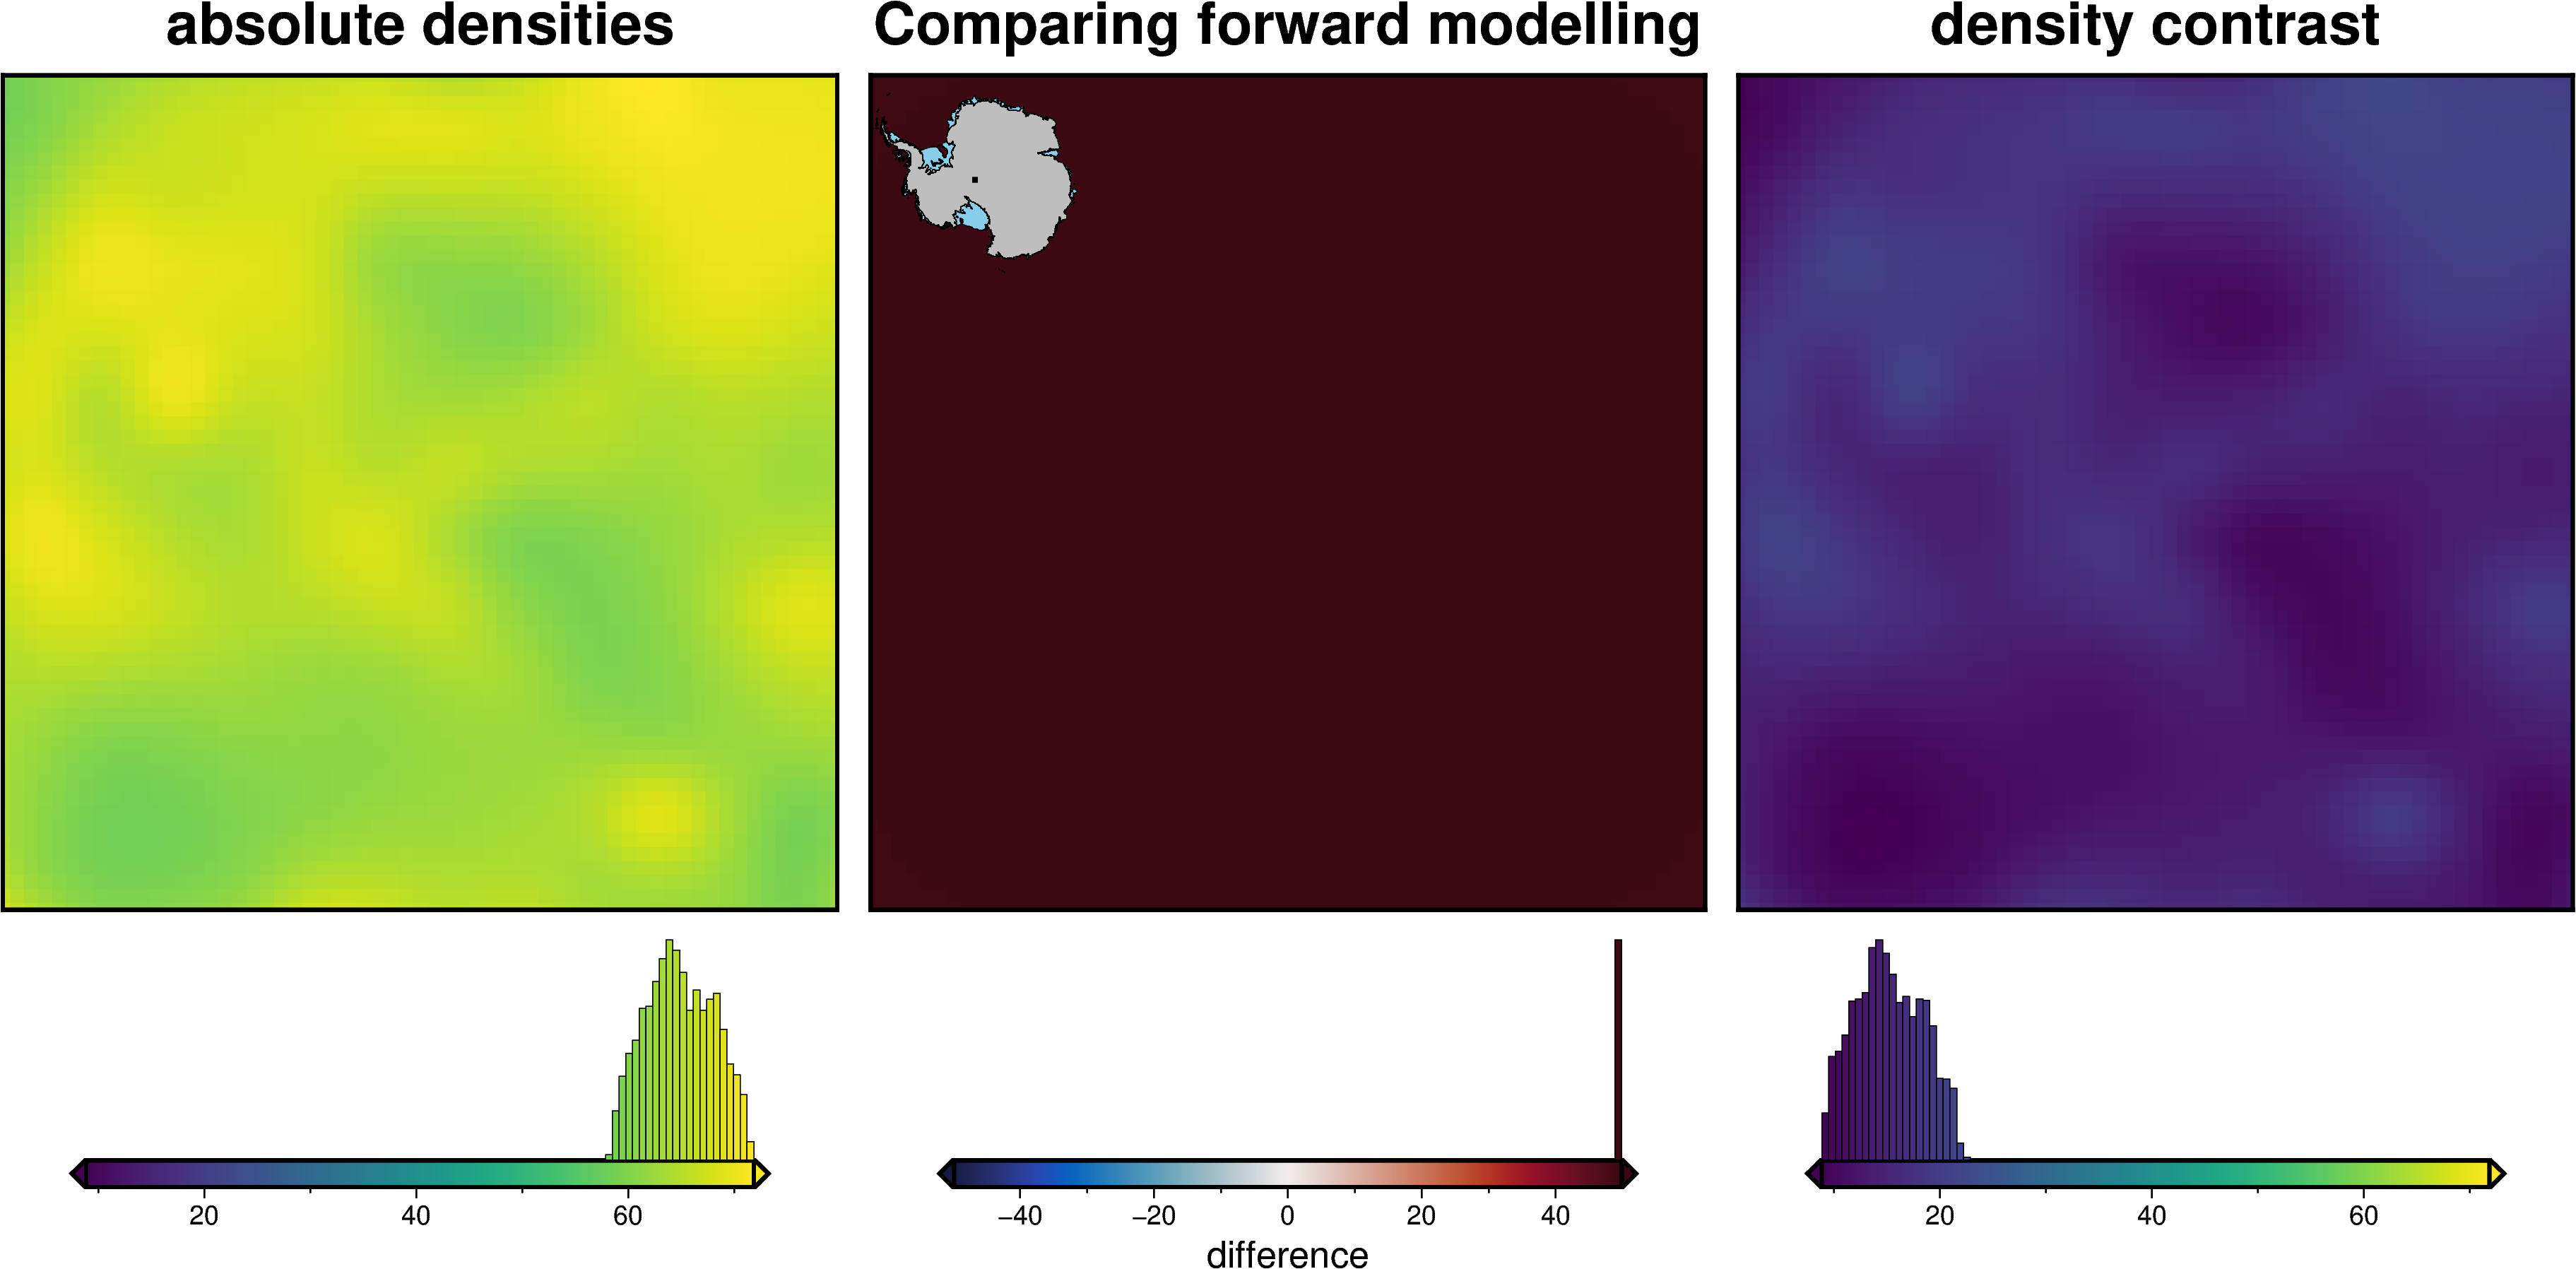

In [117]:
grids = utils.grd_compare(
    forward_absolute[2],
    forward_contrast,
    plot=True,
    grid1_name="absolute densities",
    grid2_name="density contrast",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True
)

### Normalize then compare

In [118]:
norm_forward_absolute = inv_utils.normalize_xarray(
    forward_absolute[2], 
    0, 
    100,
    )   
norm_forward_contrast = inv_utils.normalize_xarray(
    forward_contrast, 
    0, 
    100,
    )   

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


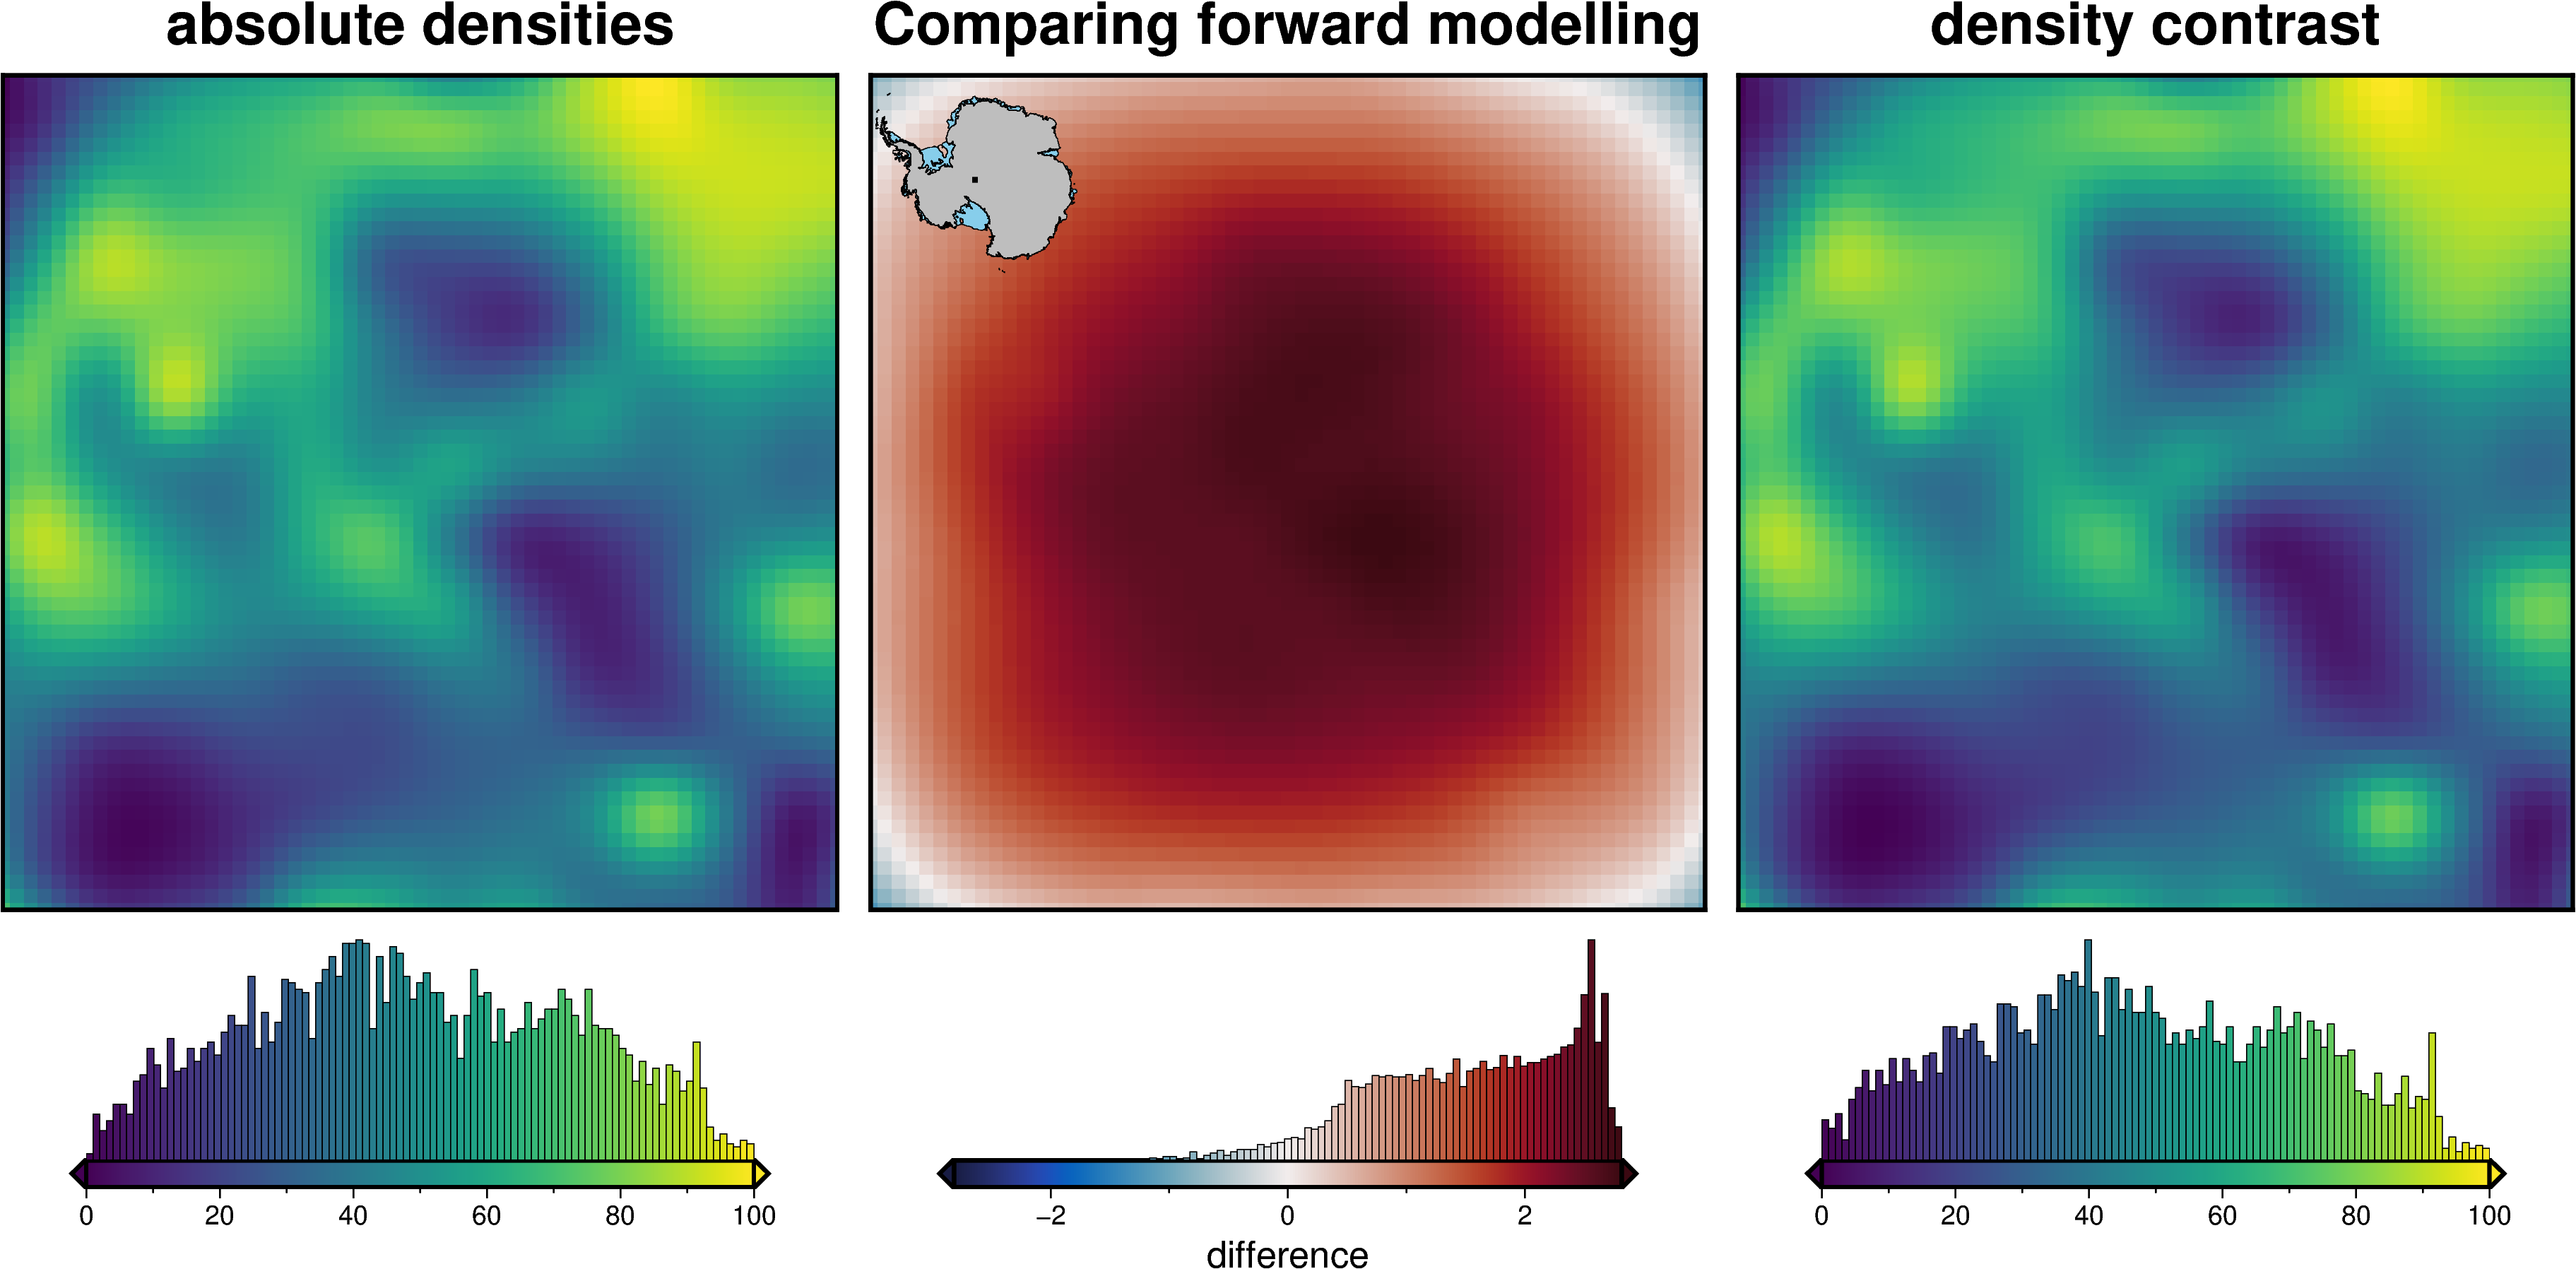

In [119]:
grids = utils.grd_compare(
    norm_forward_absolute,
    norm_forward_contrast,
    plot=True,
    grid1_name="absolute densities",
    grid2_name="density contrast",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True
)